# Бизнес постановка задачи

Автоматическая классификация отзывов по их эмоциональной окраске (положительный / отрицательный) может помочь ускорить модерацию контента, улучшить систему рекомендаций и повысить качество клиентского сервиса.

**Цель**: создать модель, которая будет автоматически определять тональность пользовательского отзыва по его тексту.

## Постановка ML-задачи

**Бинарная классификация**

На вход модель получает текст отзыва, а на выходе должна предсказать метку:
- 1 (positive) — если отзыв положительный ($Score \ge 4$),
- 0 (negative) — если отзыв отрицательный ($Score < 4$).

# 📋 Оглавление

**[1. Настройка окружения](#section-1)**

**[2. Загрузка и первичный обзор данных](#section-2)**
- 2.1 Размер и структура данных
- 2.2 Описание колонок датасета

**[3. Анализ целевой переменной и дисбаланса классов](#section-3)**
- 3.1 Распределение оценок (Score)
- 3.2 Анализ дисбаланса классов

**[4. Обоснование выбора метрик](#section-4)**

**[5. Анализ качества данных](#section-5)**
- 5.1 Пропущенные значения
- 5.2 Дубликаты строк
- 5.3 Уникальность значений

**[6. Анализ дубликатов текстов](#section-6)**

**[7. Активность пользователей и продуктов](#section-7)**

**[8. Анализ полезности отзывов (Helpfulness)](#section-8)**
- 8.1 Связь полезности с оценками
- 8.2 Распределение количества голосов
- 8.3 Коэффициент полезности (HelpfulnessRatio)

**[9. Текстовые характеристики](#section-9)**
- 9.1 Количество слов и средняя длина слова
- 9.2 Длина текста и связь с оценками
- 9.3 Статистический анализ различий
- 9.4 Связь длины текста и полезности

**[10. Корреляционный анализ признаков](#section-10)**

**[11. Временной анализ](#section-11)**

**[12. Анализ заголовков отзывов (Summary)](#section-12)**

**[13. Выводы](#section-13)**

<a id="section-1"></a>
# 1. Настройка окружения

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Markdown, display
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
import plotly.express as px
import plotly.graph_objects as go
from scipy import stats

<a id="section-2"></a>
# 2. Загрузка и первичный обзор данных

In [2]:
df_original = pd.read_csv("../data/Reviews.csv")

df = df_original.copy()

print(f"Исходные данные загружены: {df_original.shape}")
print(f"Рабочая копия создана: {df.shape}")

Исходные данные загружены: (568454, 10)
Рабочая копия создана: (568454, 10)


## 2.1 Размер и структура данных

In [3]:
df.shape

(568454, 10)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      568454 non-null  int64 
 1   ProductId               568454 non-null  object
 2   UserId                  568454 non-null  object
 3   ProfileName             568428 non-null  object
 4   HelpfulnessNumerator    568454 non-null  int64 
 5   HelpfulnessDenominator  568454 non-null  int64 
 6   Score                   568454 non-null  int64 
 7   Time                    568454 non-null  int64 
 8   Summary                 568427 non-null  object
 9   Text                    568454 non-null  object
dtypes: int64(5), object(5)
memory usage: 43.4+ MB


In [5]:
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [6]:
df.describe()

,Id,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time
count,568454.000000,568454.000000,568454.00000,568454.000000,5.684540e+05
mean,284227.500000,1.743817,2.22881,4.183199,1.296257e+09
std,164098.679298,7.636513,8.28974,1.310436,4.804331e+07
min,1.000000,0.000000,0.00000,1.000000,9.393408e+08
25%,142114.250000,0.000000,0.00000,4.000000,1.271290e+09
50%,284227.500000,0.000000,1.00000,5.000000,1.311120e+09
75%,426340.750000,2.000000,2.00000,5.000000,1.332720e+09
max,568454.000000,866.000000,923.00000,5.000000,1.351210e+09


In [7]:
df.isna().sum()

Id                         0
ProductId                  0
UserId                     0
ProfileName               26
HelpfulnessNumerator       0
HelpfulnessDenominator     0
Score                      0
Time                       0
Summary                   27
Text                       0
dtype: int64

## 2.2 Описание колонок датасета

| Column | Description |
|---------|--------------|
| **Id** | Row Id. |
| **ProductId** | Unique identifier for the product |
| **UserId** | Unqiue identifier for the user |
| **ProfileName** | Profile name of the user |
| **HelpfulnessNumerator** | Number of users who found the review helpful |
| **HelpfulnessDenominator** | Number of users who indicated whether they found the review helpful or not |
| **Score** | Rating between 1 and 5 |
| **Time** | Timestamp for the review |
| **Summary** | Brief summary of the review |
| **Text** | Text of the review |

---

### Notes
- Ratings (`Score`) are integer values from **1 to 5**.
  These can be used to define sentiment labels for classification (e.g., `Score ≥ 4 - positive`, `Score < 4 - negative`).
- The dataset contains **over 500,000 reviews**, published between **October 1999 and October 2012**.
- Some users and products appear multiple times — duplicates and identical reviews should be checked during preprocessing.
- Columns `HelpfulnessNumerator` and `HelpfulnessDenominator` can be used to measure **trustworthiness** or **reliability** of reviews.

In [8]:
df['Score'].value_counts()

Score
5    363122
4     80655
1     52268
3     42640
2     29769
Name: count, dtype: int64

<a id="section-3"></a>
# 3. Анализ целевой переменной и дисбаланса классов

## 3.1 Распределение оценок (Score)

Text(0, 0.5, 'Количество отзывов')

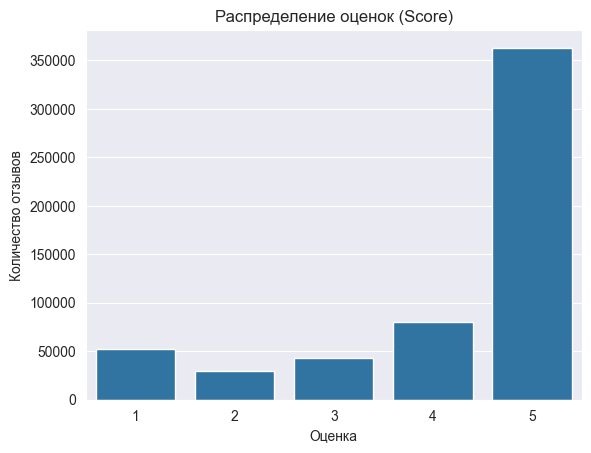

In [9]:
sns.countplot(x='Score', data=df)
plt.title("Распределение оценок (Score)")
plt.xlabel("Оценка")
plt.ylabel("Количество отзывов")

In [10]:
positive_count = (df["Score"] >= 4).sum()
negative_count = (df["Score"] < 4).sum()
total = df.shape[0]

gr_data = pd.DataFrame({
    "Класс": ["Положительный (Score ≥ 4)", "Отрицательный (Score < 4)"],
    "Количество": [positive_count, negative_count]
})
gr_data["Доля, %"] = gr_data["Количество"] / total * 100

fig = px.bar(
    gr_data,
    x='Класс',
    y='Доля, %',
    title='Распределение отзывов по классам',
    color='Класс',
    color_discrete_map={
        'Положительный (Score ≥ 4)': '#1f77b4',
        'Отрицательный (Score < 4)': '#d62728'
    },
    text='Доля, %'
)
fig.update_traces(texttemplate='%{text:.2f}%', textposition='outside')
fig.update_layout(showlegend=False, height=500)
fig.show()

display(Markdown(f"""
#### Разделения классов
Разделим на 2 класса:
- **Положительный ($Score \\ge 4$)**: {positive_count} из {total} (**{positive_count / total:.2%}**)
- **Отрицательный ($Score < 4$)**: {negative_count} из {total} (**{negative_count / total:.2%}**)
"""))


#### Разделения классов
Разделим на 2 класса:
- **Положительный ($Score \ge 4$)**: 443777 из 568454 (**78.07%**)
- **Отрицательный ($Score < 4$)**: 124677 из 568454 (**21.93%**)


## 3.2 Анализ дисбаланса классов

### Анализ распределения классов

Из графика видно, что **положительных отзывов значительно больше (~78%)**, чем отрицательных (~22%).
Это указывает на **дисбаланс классов** — модель, обученная на таких данных, может склоняться к предсказанию положительного класса, просто потому что он преобладает в обучающей выборке.

<a id="section-4"></a>
# 4. Обоснование выбора метрик

В качестве основной метрики примем *ROC-AUC* - покажет, насколько хорошо модель различает положительные и отрицательные отзывы,
независимо от выбранного порога классификации, и устойчива к дисбалансу классов.

Дополнительная метрика *F1-score* - позволит оценить баланс между точностью (precision) и полнотой (recall)
и даст более реалистичное представление о поведении модели при конкретном пороге.

Такой набор метрик обеспечит комплексную оценку:
- **ROC-AUC** — глобальное качество разделения классов
- **F1-score** — локальное качество классификации

---

**Почему не accuracy?**
- Метрика **accuracy** будет смещена в пользу большинства (положительного класса)
- Для адекватной оценки качества используем **взвешенные метрики**: F1-score, ROC-AUC, Precision/Recall

<a id="section-5"></a>
# 5. Анализ качества данных

## 5.1 Пропущенные значения

In [11]:
df.isna().sum()

Id                         0
ProductId                  0
UserId                     0
ProfileName               26
HelpfulnessNumerator       0
HelpfulnessDenominator     0
Score                      0
Time                       0
Summary                   27
Text                       0
dtype: int64

## 5.2 Дубликаты строк

Проверим есть ли явные дубликаты (полностью идентичные строки)

In [12]:
df.duplicated().sum()

np.int64(0)

In [13]:
# Удаляем дубликаты (создаем новую копию, не мутируем исходные данные)
df = df.drop_duplicates()
print(f"Размер после удаления дубликатов: {df.shape}")

Размер после удаления дубликатов: (568454, 10)


Видно, что пропуски практически отсутствуют:
- 26 пропусков в `ProfileName`
- 27 пропусков в `Summary`

Так как их немного, посмотрим на них детальнее

In [15]:
df[df["ProfileName"].isna()]

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
10616,10617,B002DHN956,A1LSYR30XW7CFT,NaN,1,2,5,1291680000,Awesome,This is 72 for the price of like 24 at the gro...
25509,25510,B000LKZB4Y,A36BVYD0NT7Z0F,NaN,0,0,5,1314576000,These are the best mints and no aspartame or BHT,I was so shocked to find out that almost all g...
38874,38875,B000AYDGZ2,A36BVYD0NT7Z0F,NaN,2,3,1,1278374400,doesn't anyone care that they are putting BHT ...,I called Kellogg's to see why Special K red be...
47923,47924,B004SRH2B6,A2DEHJJIEAPPBF,NaN,0,0,5,1338940800,Great taste,Enjoy drinking this brand. Tastes as good as ...
49800,49801,B000CRHQN0,A2LYFY32LXQDON,NaN,0,0,2,1282608000,They were melted and the chocolate had turned ...,We love these bars but i won't order them ship...
67077,67078,B0006348H2,A2P0P67Y55SNOX,NaN,1,1,5,1314662400,Wheatgrass,Kitty seems to like this sprinkled on her food...
106550,106551,B001EQ5DG0,A1P500QXEG3IUZ,NaN,0,0,5,1326758400,Finally!,"You cannot find this in the stores anymore, it..."
121819,121820,B006N3I2SK,A34F9B57SYQ5XR,NaN,0,0,5,1335312000,Exactly what I ordered,"Very good coffee, very good price. It can be ..."
125452,125453,B001EO6ESS,A34F9B57SYQ5XR,NaN,0,0,5,1335312000,Exactly what I ordered,"Very good coffee, very good price. It can be ..."
137613,137614,B000CQE3HS,AGT3BYX5P9SLH,NaN,0,0,5,1324684800,awesome,i love them they are amazing I would eat them ...


In [16]:
df[df["Summary"].isna()]

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
33958,33959,B00412W76S,A3TJPSWY2HE4BS,"S. Layton ""homeschool blogger""",1,24,2,1173312000,NaN,I only used two maybe three tea bags and got p...
40548,40549,B00020HHRW,A3TJPSWY2HE4BS,"S. Layton ""homeschool blogger""",1,24,2,1173312000,NaN,I only used two maybe three tea bags and got p...
101106,101107,B0014B0HWK,A3TJPSWY2HE4BS,"S. Layton ""homeschool blogger""",1,24,2,1173312000,NaN,I only used two maybe three tea bags and got p...
102979,102980,B000FVDWU4,A3TJPSWY2HE4BS,"S. Layton ""homeschool blogger""",1,24,2,1173312000,NaN,I only used two maybe three tea bags and got p...
117515,117516,B0016B7Z32,A3TJPSWY2HE4BS,"S. Layton ""homeschool blogger""",1,24,2,1173312000,NaN,I only used two maybe three tea bags and got p...
155712,155713,B0009VO58S,A3TJPSWY2HE4BS,"S. Layton ""homeschool blogger""",1,24,2,1173312000,NaN,I only used two maybe three tea bags and got p...
178290,178291,B00073IVAQ,A3TJPSWY2HE4BS,"S. Layton ""homeschool blogger""",1,24,2,1173312000,NaN,I only used two maybe three tea bags and got p...
198474,198475,B000FVBYCW,A3TJPSWY2HE4BS,"S. Layton ""homeschool blogger""",1,24,2,1173312000,NaN,I only used two maybe three tea bags and got p...
212691,212692,B00020HHAO,A3TJPSWY2HE4BS,"S. Layton ""homeschool blogger""",1,24,2,1173312000,NaN,I only used two maybe three tea bags and got p...
237565,237566,B000ELGPAO,A15AMT9T9A1309,Film-Friend,1,1,3,1328572800,NaN,This is a cool system only problem is that the...


Каких-то явных аномалий не видно, эти пропуски можно заменить значениями по умолчанию. Однако видно, что некоторые пользователи оставляют идентичные отзывы для разных продуктов - этот момент стоит подвергнуть дополнительному анализу далее.

In [17]:
df = df.fillna({
    "ProfileName": "UnknownUser",
    "Summary": "No summary"
})
print("Пропуски заполнены")

Пропуски заполнены


In [18]:
df.isna().sum()

Id                        0
ProductId                 0
UserId                    0
ProfileName               0
HelpfulnessNumerator      0
HelpfulnessDenominator    0
Score                     0
Time                      0
Summary                   0
Text                      0
dtype: int64

## 5.3 Уникальность значений

In [19]:
df.nunique()

Id                        568454
ProductId                  74258
UserId                    256059
ProfileName               218416
HelpfulnessNumerator         231
HelpfulnessDenominator       234
Score                          5
Time                        3168
Summary                   295743
Text                      393579
dtype: int64

<a id="section-6"></a>
# 6. Анализ дубликатов текстов

Проверим, есть ли отзывы с повторяющимся текстом (один пользователь копирует отзыв для разных продуктов).

In [20]:
duplicate_texts = df[df.duplicated(subset=['Text'], keep=False)]
unique_duplicate_texts = df[df.duplicated(subset=['Text'], keep='first')].shape[0]

print(f"Всего отзывов с повторяющимся текстом: {len(duplicate_texts)}")
print(f"Уникальных дублирующихся текстов: {unique_duplicate_texts}")
print(f"Доля дубликатов: {len(duplicate_texts) / len(df) * 100:.2f}%")

Всего отзывов с повторяющимся текстом: 232915
Уникальных дублирующихся текстов: 174875
Доля дубликатов: 40.97%


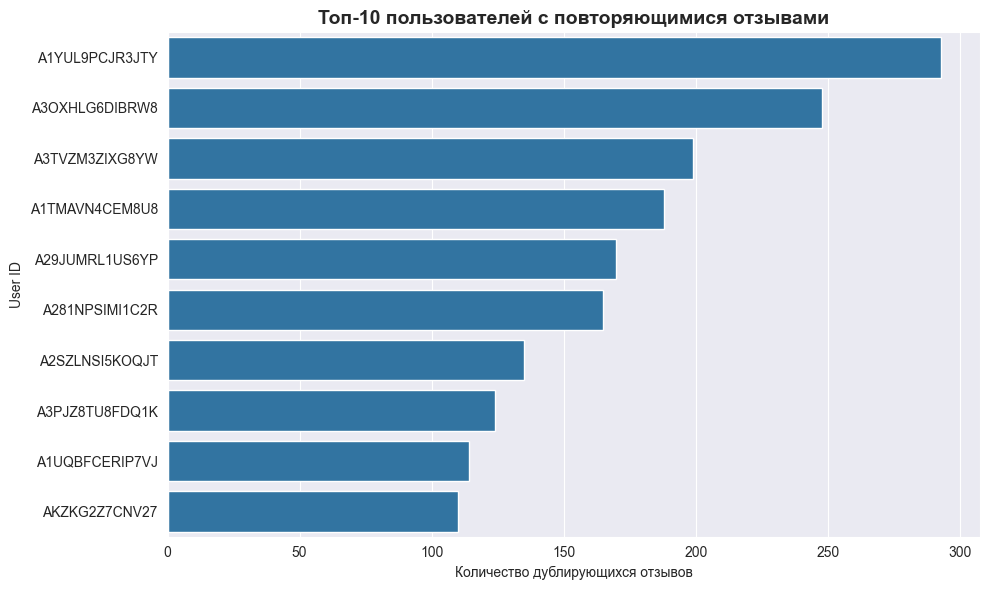


Пример дублирующегося отзыва от пользователя A1YUL9PCJR3JTY:
****<br /><br />Celestial Seasonings' Sugar Plum Spice is a delightful holiday tea. It contains hibiscus, roasted barley malt, roasted chicory root, rosehips, chamomile flowers, natural plum flavor wi...


In [21]:
if len(duplicate_texts) > 0:
    duplicate_users = duplicate_texts.groupby('UserId')['Text'].count().sort_values(ascending=False).head(10)
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x=duplicate_users.values, y=duplicate_users.index)
    plt.title('Топ-10 пользователей с повторяющимися отзывами', fontsize=14, weight='bold')
    plt.xlabel('Количество дублирующихся отзывов')
    plt.ylabel('User ID')
    plt.tight_layout()
    plt.show()
    
    print(f"\nПример дублирующегося отзыва от пользователя {duplicate_users.index[0]}:")
    print(duplicate_texts[duplicate_texts['UserId'] == duplicate_users.index[0]]['Text'].iloc[0][:200] + "...")
else:
    print("Дубликаты не найдены")

**Выводы о дубликатах:**
- Некоторые пользователи копируют один и тот же отзыв для разных продуктов (возможно, спам или автоматическая генерация)
- На этапе предварительной обратки данных стоит рассмотреть удаление таких дубликатов, чтобы избежать переобучения модели на повторяющихся паттернах

<a id="section-7"></a>
# 7. Активность пользователей и продуктов

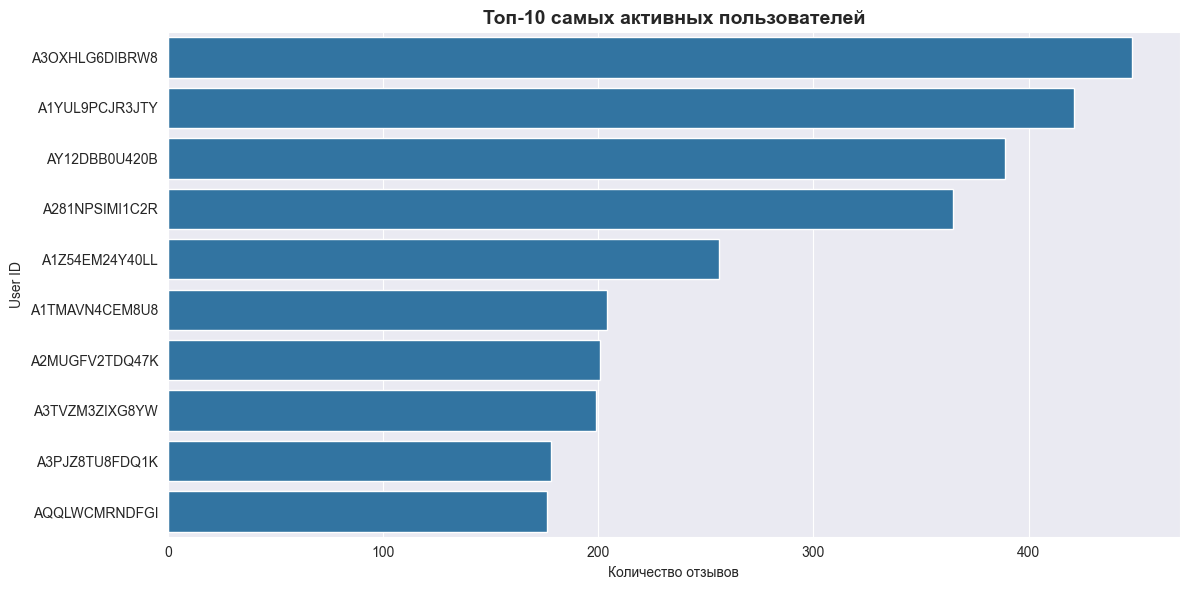

Максимальное количество отзывов от одного пользователя: 448
Медианное количество отзывов на пользователя: 1


In [22]:
top_users = df['UserId'].value_counts().head(10)

plt.figure(figsize=(12, 6))
sns.barplot(x=top_users.values, y=top_users.index)
plt.title('Топ-10 самых активных пользователей', fontsize=14, weight='bold')
plt.xlabel('Количество отзывов')
plt.ylabel('User ID')
plt.tight_layout()
plt.show()

print(f"Максимальное количество отзывов от одного пользователя: {top_users.iloc[0]}")
print(f"Медианное количество отзывов на пользователя: {df['UserId'].value_counts().median():.0f}")

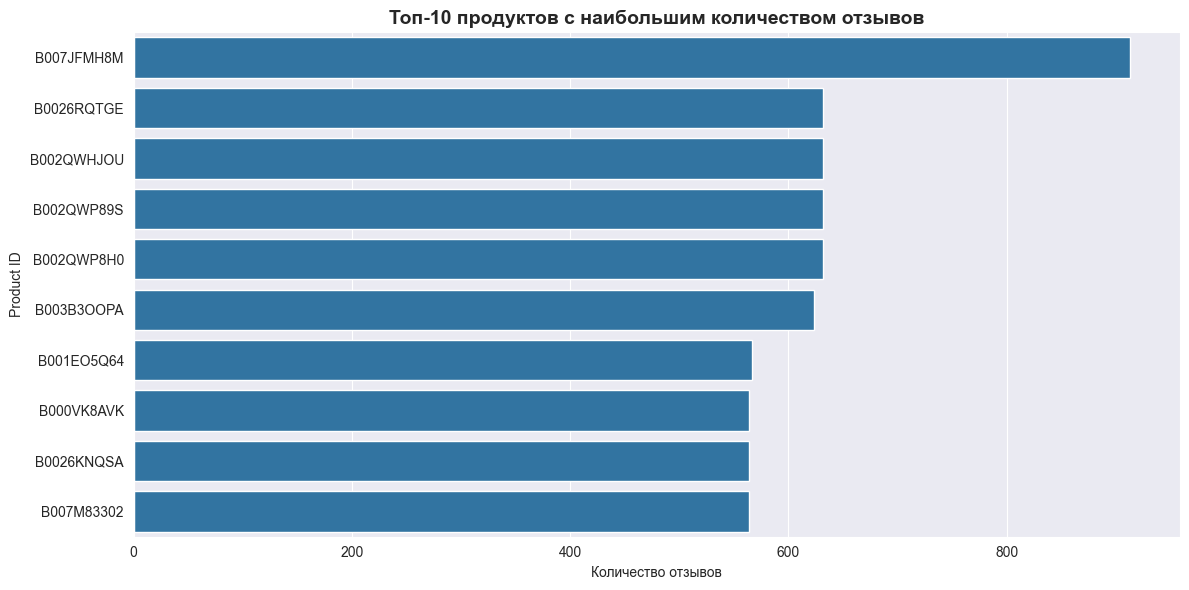

Максимальное количество отзывов на один продукт: 913
Медианное количество отзывов на продукт: 2


In [23]:
top_products = df['ProductId'].value_counts().head(10)

plt.figure(figsize=(12, 6))
sns.barplot(x=top_products.values, y=top_products.index)
plt.title('Топ-10 продуктов с наибольшим количеством отзывов', fontsize=14, weight='bold')
plt.xlabel('Количество отзывов')
plt.ylabel('Product ID')
plt.tight_layout()
plt.show()

print(f"Максимальное количество отзывов на один продукт: {top_products.iloc[0]}")
print(f"Медианное количество отзывов на продукт: {df['ProductId'].value_counts().median():.0f}")

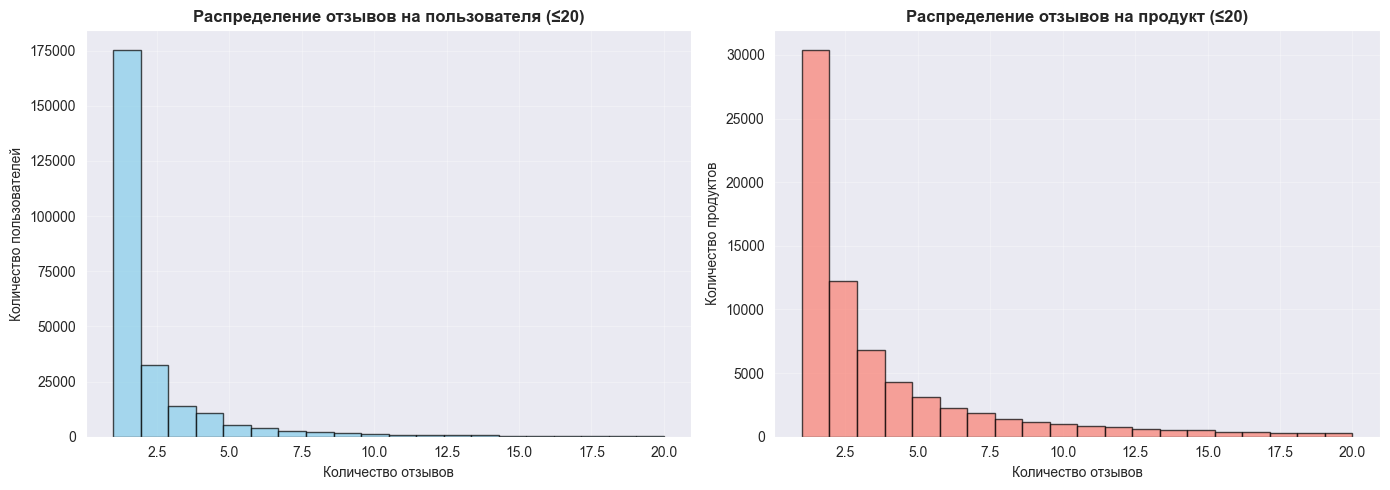

In [24]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

user_review_counts = df['UserId'].value_counts()
axes[0].hist(user_review_counts[user_review_counts <= 20], bins=20, edgecolor='black', alpha=0.7, color='skyblue')
axes[0].set_title('Распределение отзывов на пользователя (≤20)', fontsize=12, weight='bold')
axes[0].set_xlabel('Количество отзывов')
axes[0].set_ylabel('Количество пользователей')
axes[0].grid(alpha=0.3)

product_review_counts = df['ProductId'].value_counts()
axes[1].hist(product_review_counts[product_review_counts <= 20], bins=20, edgecolor='black', alpha=0.7, color='salmon')
axes[1].set_title('Распределение отзывов на продукт (≤20)', fontsize=12, weight='bold')
axes[1].set_xlabel('Количество отзывов')
axes[1].set_ylabel('Количество продуктов')
axes[1].grid(alpha=0.3)

plt.tight_layout()

### Замечание

Колонка `Id` не несет никакой полезной информации для анализа, поэтому удаляем ее из рабочего датасета.

In [25]:
# Удаляем колонку Id (не несет полезной информации)
df = df.drop(columns=['Id'])
print(f"Колонка 'Id' удалена. Новая форма: {df.shape}")

Колонка 'Id' удалена. Новая форма: (568454, 9)


Text(0.5, 1.0, 'Распределение полезности по оценкам')

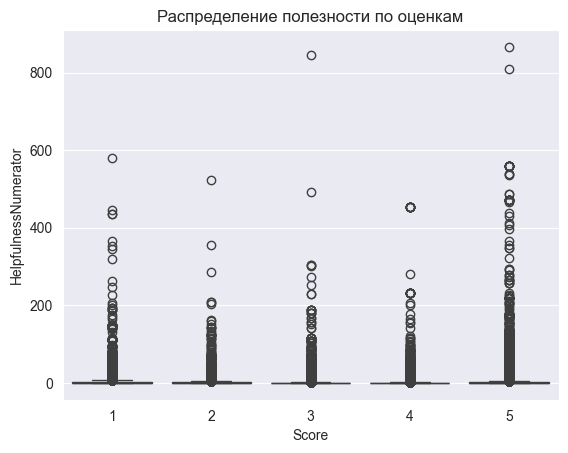

In [26]:
sns.boxplot(x="Score", y="HelpfulnessNumerator", data=df)
plt.title("Распределение полезности по оценкам")

<a id="section-8"></a>
# 8. Анализ полезности отзывов (Helpfulness)

## 8.1 Связь полезности с оценками

In [27]:
pos_helpful_sum = df[df["Score"] > 3]["HelpfulnessNumerator"].sum()
neg_helpful_sum = df[df["Score"] < 4]["HelpfulnessNumerator"].sum()

pos_count = df[df["Score"] > 3].shape[0]
neg_count = df[df["Score"] < 4].shape[0]

mean_pos_count = pos_helpful_sum / pos_count
mean_neg_count = neg_helpful_sum / neg_count

display(Markdown(f"""
#### Разделение голосов за отзывы по оценкам:
- Положительные отзывы: {pos_helpful_sum} голосов
- Отрицательные отзывы: {neg_helpful_sum} голосов

#### Среднее число голосов "полезно" на 1 отзыв:
- Положительные: {mean_pos_count:.2f}
- Отрицательные: {mean_neg_count:.2f}
"""))


#### Разделение голосов за отзывы по оценкам:
- Положительные отзывы: 720446 голосов
- Отрицательные отзывы: 270834 голосов

#### Среднее число голосов "полезно" на 1 отзыв:
- Положительные: 1.62
- Отрицательные: 2.17


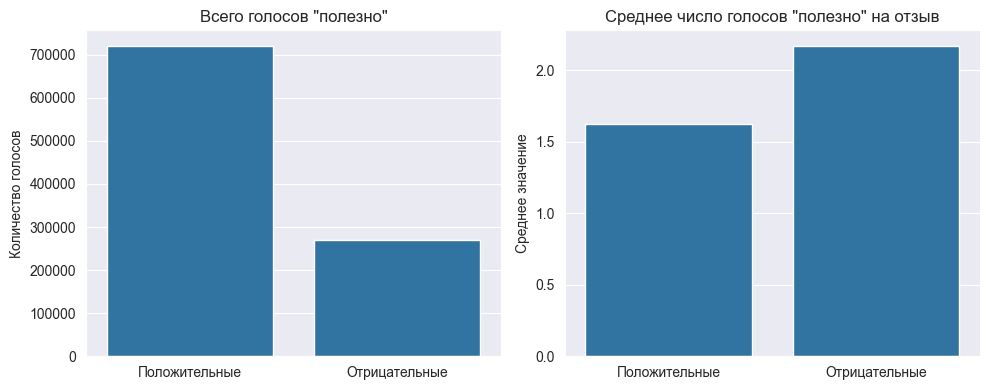

In [28]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
sns.barplot(x=['Положительные', 'Отрицательные'],
            y=[pos_helpful_sum, neg_helpful_sum],
            ax=axes[0])
axes[0].set_title('Всего голосов "полезно"')
axes[0].set_ylabel('Количество голосов')

sns.barplot(x=['Положительные', 'Отрицательные'],
            y=[mean_pos_count, mean_neg_count],
            ax=axes[1])
axes[1].set_title('Среднее число голосов "полезно" на отзыв')
axes[1].set_ylabel('Среднее значение')

plt.tight_layout()

Положительные отзывы получают кратно больше голосов, но более полезными пользователи считают именно негативные отзывы. Выдвинем гипотезу, что пользователи больше ценят критические отзывы, а положительные считают менее информативными.

In [29]:
df['HelpfulnessDenominator'].describe()

count    568454.00000
mean          2.22881
std           8.28974
min           0.00000
25%           0.00000
50%           1.00000
75%           2.00000
max         923.00000
Name: HelpfulnessDenominator, dtype: float64

## 8.2 Распределение количества голосов (HelpfulnessDenominator)

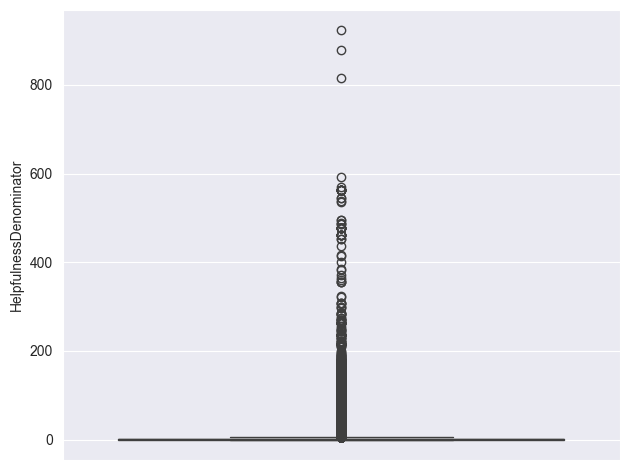

In [30]:
sns.boxplot(df['HelpfulnessDenominator'])

plt.tight_layout()

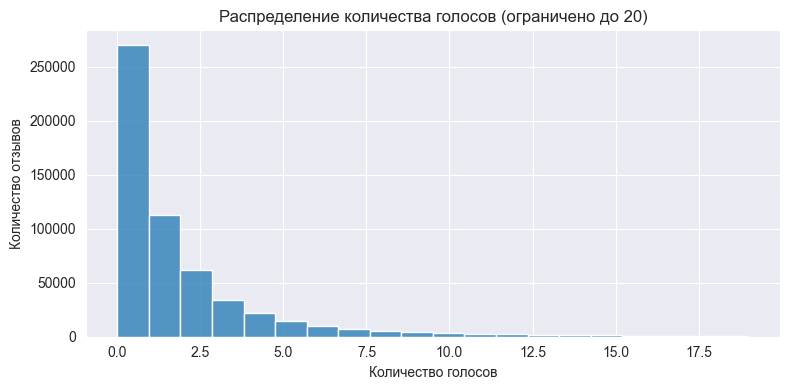

In [31]:
plt.figure(figsize=(8, 4))
sns.histplot(df[df['HelpfulnessDenominator'] < 20]['HelpfulnessDenominator'], bins=20)
plt.title('Распределение количества голосов (ограничено до 20)')
plt.xlabel('Количество голосов')
plt.ylabel('Количество отзывов')

plt.tight_layout()

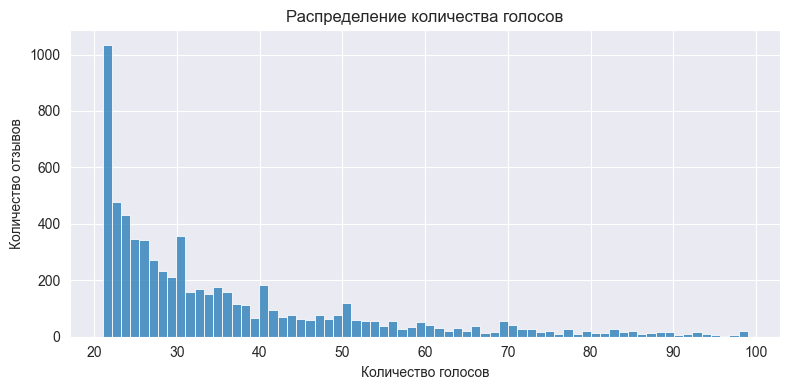

In [32]:
plt.figure(figsize=(8, 4))
sns.histplot(df[(df['HelpfulnessDenominator'] > 20) & (df['HelpfulnessDenominator'] < 100)]['HelpfulnessDenominator'], bins=70)
plt.title('Распределение количества голосов')
plt.xlabel('Количество голосов')
plt.ylabel('Количество отзывов')

plt.tight_layout()

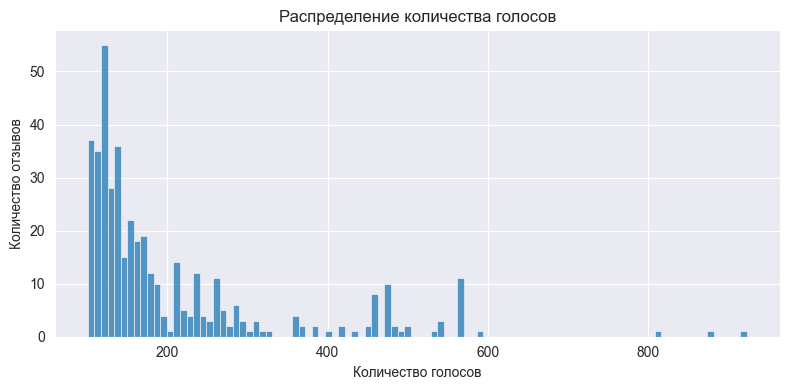

In [33]:
plt.figure(figsize=(8, 4))
sns.histplot(df[df['HelpfulnessDenominator'] > 100]['HelpfulnessDenominator'], bins=100)
plt.title('Распределение количества голосов')
plt.xlabel('Количество голосов')
plt.ylabel('Количество отзывов')

plt.tight_layout()

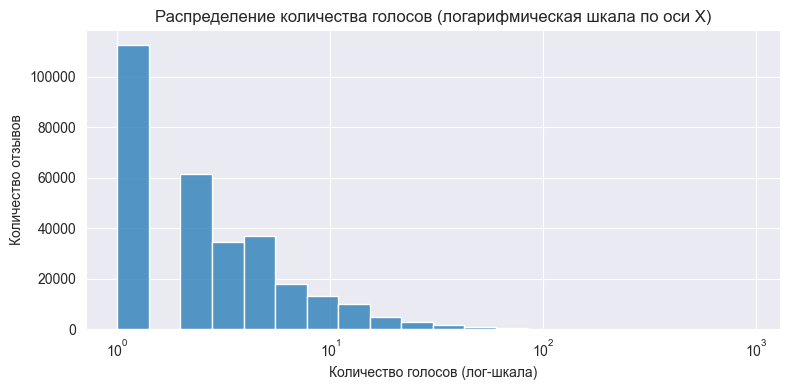

In [34]:
plt.figure(figsize=(8, 4))
sns.histplot(df['HelpfulnessDenominator'], bins=20, log_scale=(True, False))
plt.title('Распределение количества голосов (логарифмическая шкала по оси X)')
plt.xlabel('Количество голосов (лог-шкала)')
plt.ylabel('Количество отзывов')

plt.tight_layout()

### Выводы по распределению

`HelpfulnessDenominator` имеет тяжёлое правостороннее распределение: подавляющее большинство отзывов имеют 0–3 оценки полезности, но встречаются редкие случаи с сотнями голосов. Логарифмирование (log1p) позволяет сделать распределение более симметричным и уменьшить влияние выбросов.

## 8.3 Коэффициент полезности (HelpfulnessRatio)

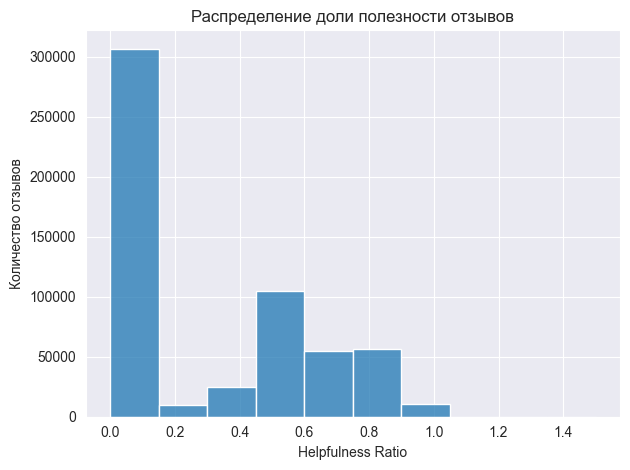

In [35]:
df['HelpfulnessRatio'] = df['HelpfulnessNumerator'] / (df['HelpfulnessDenominator'] + 1)

sns.histplot(df['HelpfulnessRatio'], bins=10)
plt.title("Распределение доли полезности отзывов")
plt.xlabel("Helpfulness Ratio")
plt.ylabel("Количество отзывов")

plt.tight_layout()

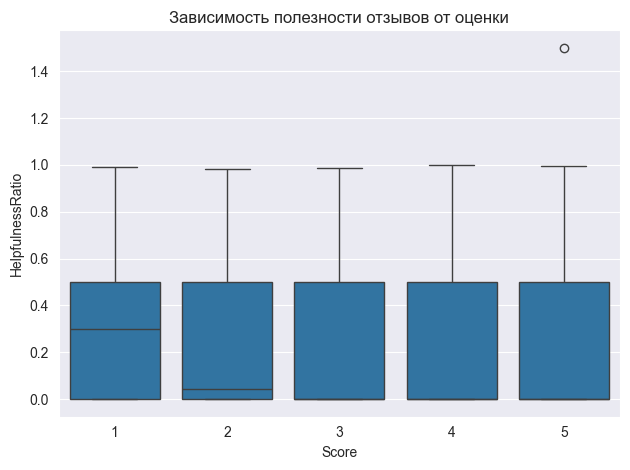

In [36]:
sns.boxplot(x='Score', y='HelpfulnessRatio', data=df)
plt.title("Зависимость полезности отзывов от оценки")

plt.tight_layout()

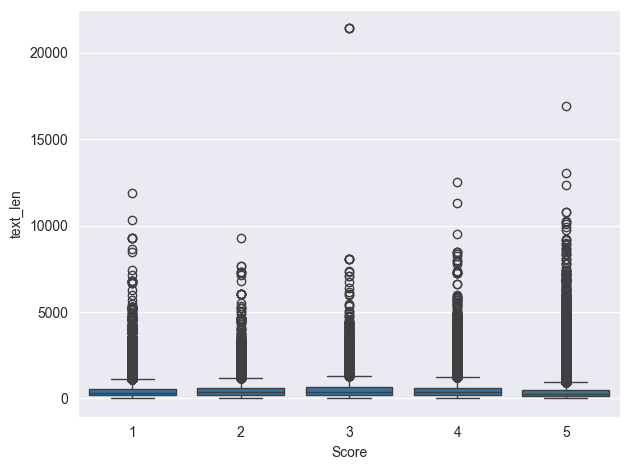

In [37]:
df['text_len'] = df['Text'].apply(len)
sns.boxplot(x='Score', y='text_len', data=df)

plt.tight_layout()

### Выводы по длине текста

Видно, что пользователи, которые ставят негативные оценки, в среднем пишут более короткие отзывы.

<a id="section-9"></a>
# 9. Текстовые характеристики

## 9.1 Количество слов и средняя длина слова

In [39]:
df['word_count'] = df['Text'].str.split().str.len()
df['avg_word_len'] = df['Text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]) if len(str(x).split()) > 0 else 0)

print("Статистики по количеству слов:")
print(df['word_count'].describe())
print("\nСтатистики по средней длине слова:")
print(df['avg_word_len'].describe())

Статистики по количеству слов:
count    568454.000000
mean         80.264023
std          79.455384
min           3.000000
25%          33.000000
50%          56.000000
75%          98.000000
max        3432.000000
Name: word_count, dtype: float64

Статистики по средней длине слова:
count    568454.000000
mean          4.400934
std           0.441144
min           1.000000
25%           4.120000
50%           4.360000
75%           4.625000
max          35.296296
Name: avg_word_len, dtype: float64


## 9.2 Длина текста и связь с оценками

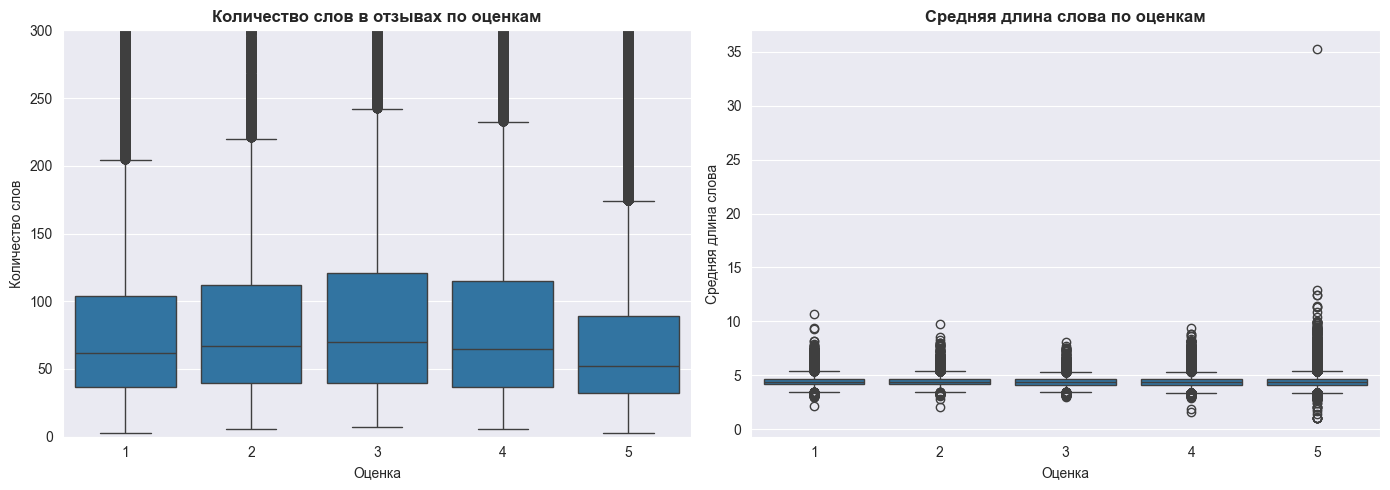

In [40]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.boxplot(x='Score', y='word_count', data=df, ax=axes[0])
axes[0].set_title('Количество слов в отзывах по оценкам', fontsize=12, weight='bold')
axes[0].set_xlabel('Оценка')
axes[0].set_ylabel('Количество слов')
axes[0].set_ylim(0, 300)

sns.boxplot(x='Score', y='avg_word_len', data=df, ax=axes[1])
axes[1].set_title('Средняя длина слова по оценкам', fontsize=12, weight='bold')
axes[1].set_xlabel('Оценка')
axes[1].set_ylabel('Средняя длина слова')

plt.tight_layout()
plt.show()

In [42]:
positive_word_count = df[df['Score'] >= 4]['word_count']
negative_word_count = df[df['Score'] < 4]['word_count']

t_stat, p_value = stats.ttest_ind(positive_word_count, negative_word_count)

print(f"T-статистика: {t_stat:.4f}")
print(f"P-значение: {p_value:.4e}")
print(f"\nСреднее количество слов в положительных отзывах: {positive_word_count.mean():.2f}")
print(f"Среднее количество слов в отрицательных отзывах: {negative_word_count.mean():.2f}")

if p_value < 0.05:
    print("\nРазличие статистически значимо (p < 0.05)")
    print("Отрицательные отзывы в среднем длиннее, что может быть полезным признаком для модели")
else:
    print("\n Различие не является статистически значимым (p >= 0.05)")

T-статистика: -53.2178
P-значение: 0.0000e+00

Среднее количество слов в положительных отзывах: 77.30
Среднее количество слов в отрицательных отзывах: 90.82

Различие статистически значимо (p < 0.05)
Отрицательные отзывы в среднем длиннее, что может быть полезным признаком для модели


## 9.3 Статистический анализ различий между классами

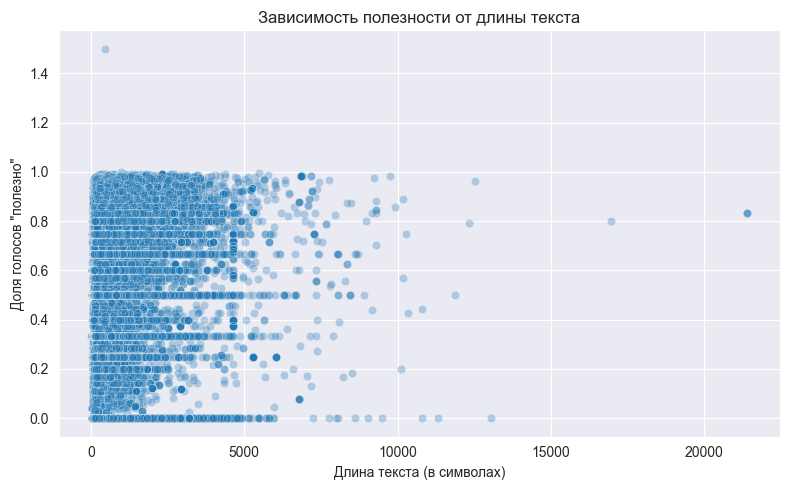

In [43]:
plt.figure(figsize=(8, 5))
sns.scatterplot(x='text_len', y='HelpfulnessRatio', data=df, alpha=0.3)
plt.title('Зависимость полезности от длины текста')
plt.xlabel('Длина текста (в символах)')
plt.ylabel('Доля голосов "полезно"')
plt.tight_layout()

## 9.4 Связь длины текста и полезности отзывов

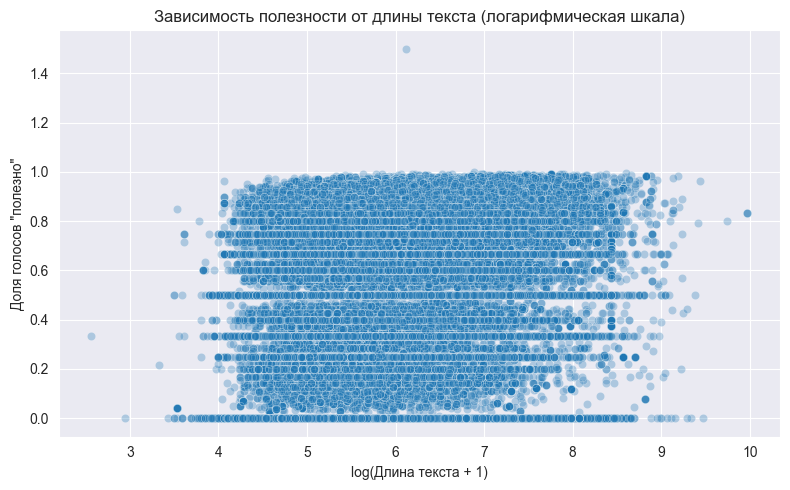

In [44]:
plt.figure(figsize=(8, 5))
sns.scatterplot(x=np.log1p(df['text_len']), y='HelpfulnessRatio', data=df, alpha=0.3)
plt.title('Зависимость полезности от длины текста (логарифмическая шкала)')
plt.xlabel('log(Длина текста + 1)')
plt.ylabel('Доля голосов "полезно"')
plt.tight_layout()

In [46]:
sample_df = df.sample(n=min(5000, len(df)), random_state=42)

fig = px.scatter_3d(
    sample_df,
    x='text_len',
    y='HelpfulnessRatio',
    z='Score',
    color='Score',
    title='3D анализ: длина текста, полезность и оценка',
    labels={
        'text_len': 'Длина текста',
        'HelpfulnessRatio': 'Доля полезности',
        'Score': 'Оценка'
    },
    color_continuous_scale='RdYlGn',
    opacity=0.6,
    height=600
)
fig.update_traces(marker=dict(size=3))

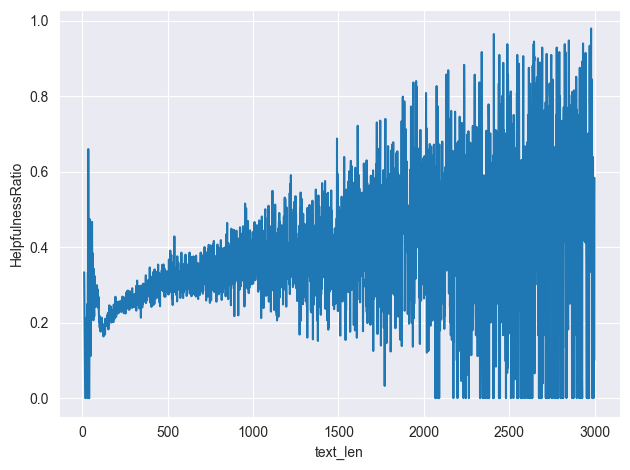

In [47]:
sns.lineplot(
    x='text_len',
    y='HelpfulnessRatio',
    data=df[df['text_len'] < 3000],
    errorbar=None
)
plt.tight_layout()

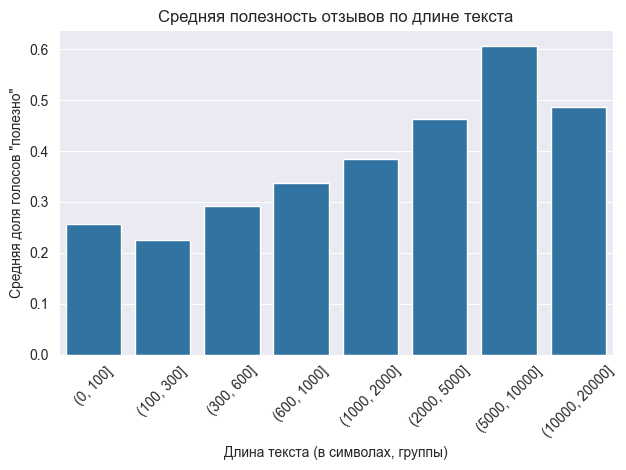

In [48]:
df['len_group'] = pd.cut(df['text_len'], bins=[0,100,300,600,1000,2000,5000,10000,20000])

mean_ratio = df.groupby('len_group', observed=True)['HelpfulnessRatio'].mean().reset_index()

sns.barplot(x='len_group', y='HelpfulnessRatio', data=mean_ratio)
plt.xticks(rotation=45)
plt.title('Средняя полезность отзывов по длине текста')
plt.xlabel('Длина текста (в символах, группы)')
plt.ylabel('Средняя доля голосов "полезно"')
plt.tight_layout()

### Выводы

Видно, что чем отзыв длиннее, тем он более полезен, но также из графиков видно, что короткие отзывы не всегда бесполезны.

<a id="section-10"></a>
# 10. Корреляционный анализ признаков

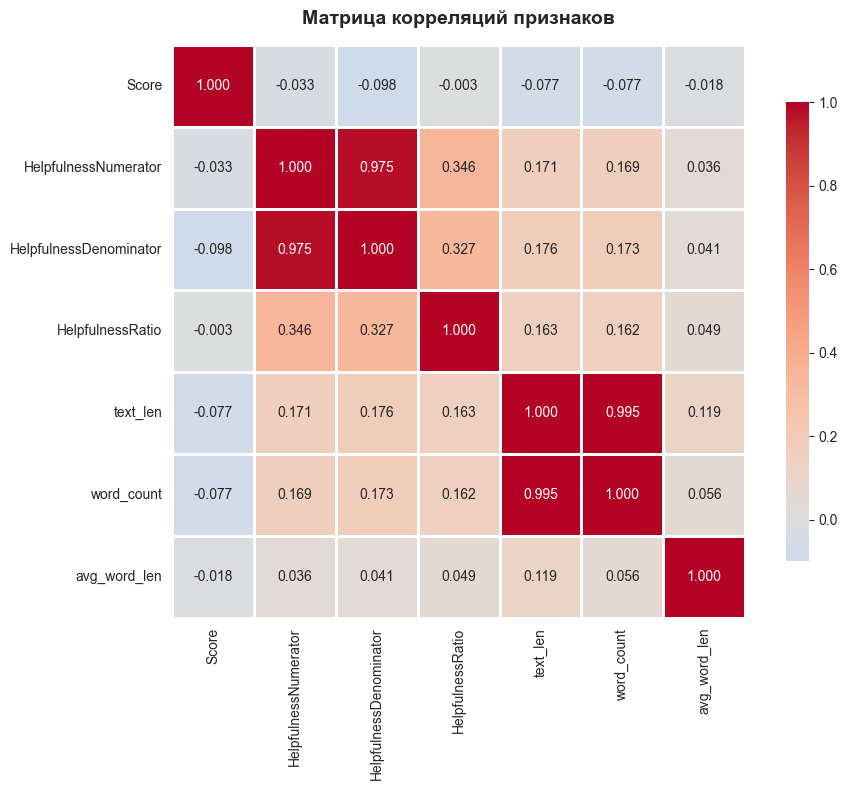

In [49]:
corr_features = ['Score', 'HelpfulnessNumerator', 'HelpfulnessDenominator',
                 'HelpfulnessRatio', 'text_len', 'word_count', 'avg_word_len']

correlation_matrix = df[corr_features].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt='.3f', cmap='coolwarm', 
            center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Матрица корреляций признаков', fontsize=14, weight='bold', pad=15)
plt.tight_layout()
plt.show()

**Наблюдения по корреляциям:**
- `HelpfulnessNumerator` и `HelpfulnessDenominator` имеют высокую корреляцию (ожидаемо)
- `Score` имеет слабую отрицательную корреляцию с длиной текста - пользователи с негативными отзывами пишут меньше
- `HelpfulnessRatio` и `Score` могут иметь связь - проверим далее

<a id="section-11"></a>
# 11. Временной анализ

Проанализируем динамику отзывов во времени и изменение средних оценок.

In [50]:
df['Time'] = pd.to_datetime(df['Time'], unit='s')

In [51]:
df['year'] = df['Time'].dt.year
df['month'] = df['Time'].dt.month
df['dayofweek'] = df['Time'].dt.dayofweek

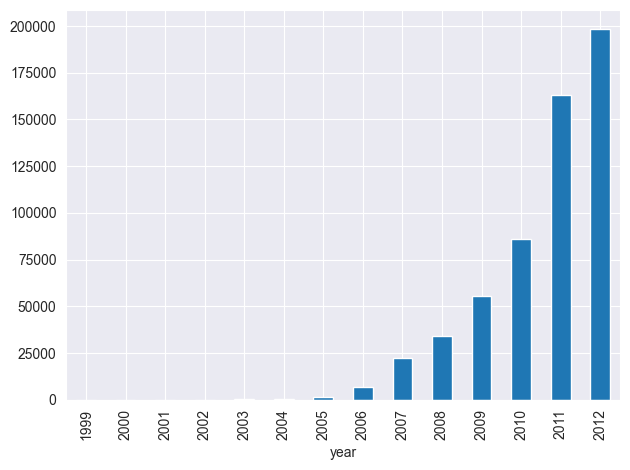

In [52]:
df['year'].value_counts().sort_index().plot(kind='bar')

plt.tight_layout()

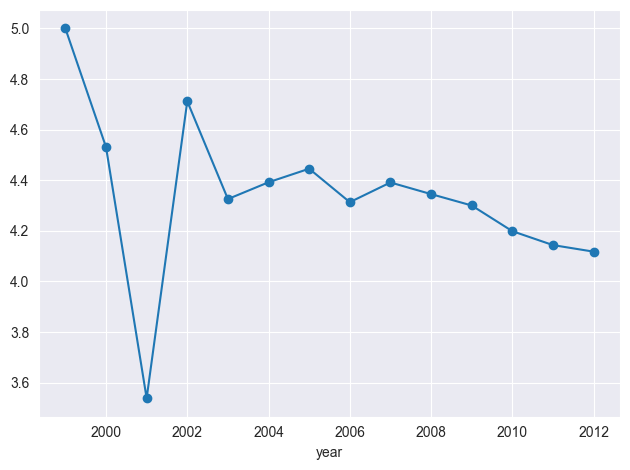

In [53]:
df.groupby('year')['Score'].mean().plot(marker='o')

plt.tight_layout()

In [54]:
yearly_stats = df.groupby('year').agg({
    'Score': ['mean', 'count']
}).reset_index()
yearly_stats.columns = ['year', 'avg_score', 'count']

fig = go.Figure()
fig.add_trace(go.Scatter(
    x=yearly_stats['year'], 
    y=yearly_stats['avg_score'],
    mode='lines+markers',
    name='Средняя оценка',
    marker=dict(size=8, color='#1f77b4'),
    line=dict(width=2),
    hovertemplate='<b>Год</b>: %{x}<br><b>Средняя оценка</b>: %{y:.2f}<extra></extra>'
))

fig.update_layout(
    title='Изменение средней оценки по годам',
    xaxis_title='Год',
    yaxis_title='Средняя оценка',
    hovermode='x unified',
    height=500
)

Видим, что активность растет с каждым годом, но средняя оценка падает. Видимо раньше было лучше)
Так же интересно резкое падение с 2000 по 2002

In [55]:
df['year'].value_counts().sort_index()

year
1999         6
2000        32
2001        13
2002        73
2003       132
2004       561
2005      1335
2006      6671
2007     22300
2008     34163
2009     55326
2010     85884
2011    163299
2012    198659
Name: count, dtype: int64

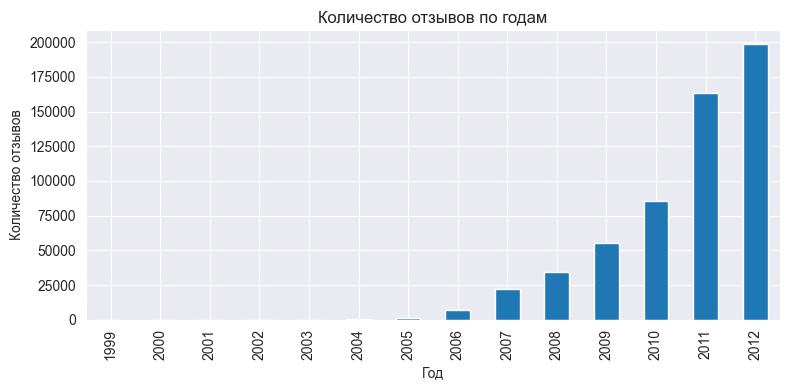

In [56]:
df['year'].value_counts().sort_index().plot(kind='bar', figsize=(8, 4))
plt.title('Количество отзывов по годам')
plt.xlabel('Год')
plt.ylabel('Количество отзывов')
plt.tight_layout()


Очевидно, что до 2006 просто очень мало отзывов

In [57]:
df['summary_len'] = df['Summary'].astype(str).apply(len)

<a id="section-12"></a>
# 12. Анализ заголовков отзывов (Summary)

Проанализируем связь длины заголовка с оценкой и наиболее частые слова в заголовках.

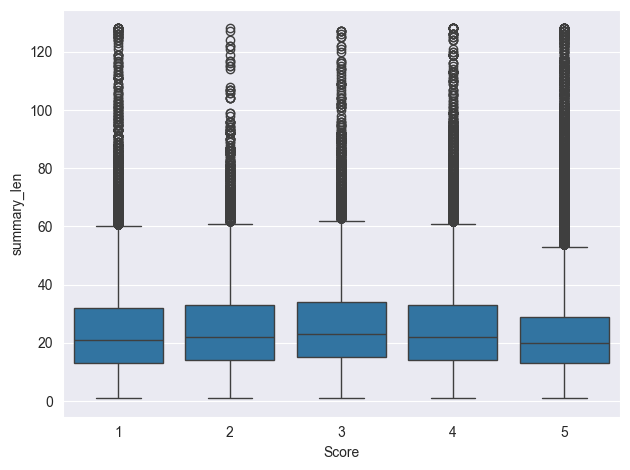

In [58]:
sns.boxplot(x='Score', y='summary_len', data=df)

plt.tight_layout()

Только отзывы с самой высокой оценкой в среднем имеют более короткие заголовки

In [59]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def clean_text(text):
    if isinstance(text, str):
        words = text.lower().split()
        words = [w for w in words if w.isalpha() and w not in stop_words]
        return " ".join(words)
    return ""

df['clean_summary'] = df['Summary'].apply(clean_text)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/dtsyplyackov/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [60]:
positive_summaries = " ".join(df[df['Score'] >= 4]['clean_summary'])
negative_summaries = " ".join(df[df['Score'] < 4]['clean_summary'])

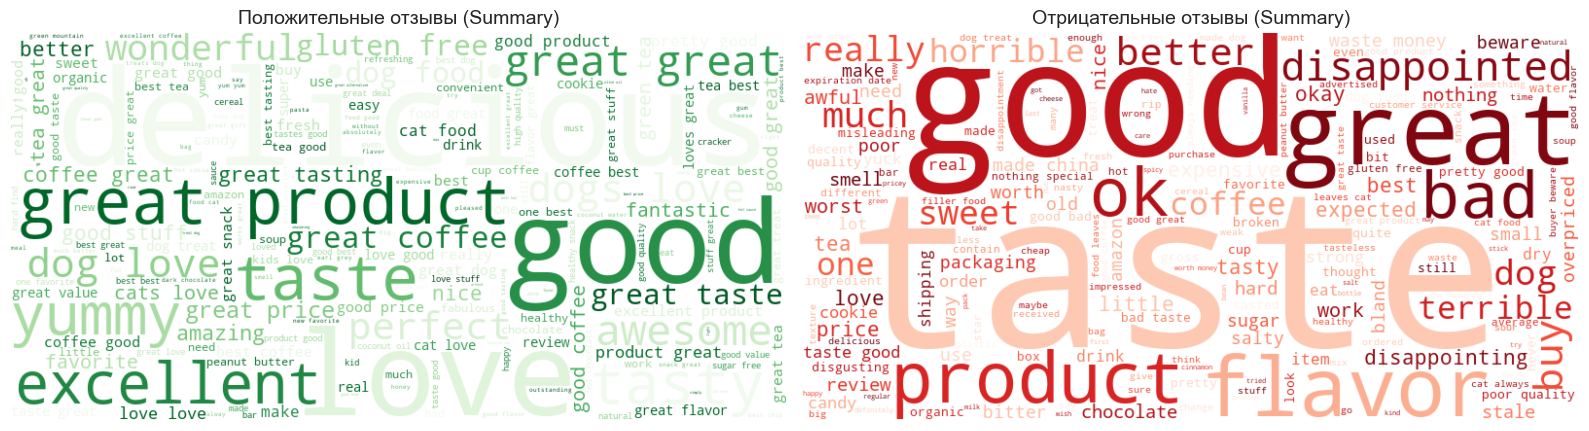

In [61]:
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

wc_pos = WordCloud(width=800, height=400, background_color='white', colormap='Greens').generate(positive_summaries)
axes[0].imshow(wc_pos, interpolation='bilinear')
axes[0].axis('off')
axes[0].set_title('Положительные отзывы (Summary)', fontsize=14)

wc_neg = WordCloud(width=800, height=400, background_color='white', colormap='Reds').generate(negative_summaries)
axes[1].imshow(wc_neg, interpolation='bilinear')
axes[1].axis('off')
axes[1].set_title('Отрицательные отзывы (Summary)', fontsize=14)

plt.tight_layout()

<a id="section-13"></a>
# 13. Выводы

## Основные выводы из EDA

### 1. Дисбаланс классов
- **Положительные отзывы** (Score ≥ 4): ~78%
- **Отрицательные отзывы** (Score < 4): ~22%
- **Вывод**: Модель может быть смещена к предсказанию положительного класса

### 2. Качество данных
- Пропуски минимальны (26 в ProfileName, 27 в Summary) — обработаны заменой на дефолтные значения
- Найдены **дубликаты текстов** — некоторые пользователи копируют один отзыв для разных продуктов
- Удалить дубликаты перед обучением модели для избежания утечки данных

### 3. Текстовые характеристики
- **Длина текста** коррелирует с оценкой:
  - Отрицательные отзывы (Score < 4) в среднем **длиннее**
  - Статистически значимое различие подтверждено t-тестом (p < 0.05)
- **Полезность отзывов**:
  - Отрицательные отзывы получают более высокий рейтинг полезности
  - Длинные отзывы считаются более полезными
- **Признаки для модели**:
  - `text_len` (длина текста в символах)
  - `word_count` (количество слов)
  - `avg_word_len` (средняя длина слова)
  - `HelpfulnessRatio` (доля полезности)

### 4. Временные тренды
- Количество отзывов растет экспоненциально с 2006 года
- **Средняя оценка снижается со временем** — возможен **temporal drift**
- Рассмотреть разделение train/test по времени, а не случайным образом

### 5. Активность пользователей и продуктов
- Большинство пользователей оставляют 1-2 отзыва
- Есть **суперактивные пользователи** (100+ отзывов) — могут быть ботами или профессиональными ревьюерами
- Некоторые продукты имеют сотни отзывов, что может влиять на обобщающую способность модели